In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamzampsy","key":"dad9c0e2c87eec6475ab0d8d37c9ba1e"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download 'jessicali9530/celeba-dataset'

100% 1.33G/1.33G [00:52<00:00, 35.8MB/s]
100% 1.33G/1.33G [00:52<00:00, 27.2MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision.datasets as ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
import natsort

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [29]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a List
    '''
    def __init__(self, z_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8 , stride=1,padding = 0),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim ),
            self.make_gen_block(hidden_dim, im_chan,final_layer=True)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,out_channels=output_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
                nn.BatchNorm2d(num_features=output_channels),
                nn.ReLU(True)    
            )
        # Final Layer
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=input_channels,out_channels=output_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias= False),
            nn.Tanh()
        )
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [30]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim *4, hidden_dim * 8),
            self.make_disc_block(hidden_dim *8, 1,stride = 1,padding = 0, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,out_channels=output_channels,kernel_size=kernel_size,stride=stride,padding=padding),
                nn.BatchNorm2d(num_features=output_channels),
                nn.LeakyReLU(negative_slope = 0.2)
            )
        # Final Layer
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels,out_channels=output_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.Sigmoid()
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [31]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [32]:
criterion = nn.BCEWithLogitsLoss().cuda()
z_dim = 100
image_size = 64
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'
dataroot = 'img_align_celeba'
# Create the dataset
transform=transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageFolder.ImageFolder('img_align_celeba',transform=transform)
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [33]:
gen = Generator().to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
# Training Loop
fixed_noise = get_noise(1,z_dim,device=device)
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
n_epochs = 5
cur_step = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real = data[0].to(device)
       
        b_size = real.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = get_noise(b_size,z_dim,device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(0.)
        # Classify all fake batch with D
        output = disc(fake.detach().cuda()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        disc_opt.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(1.)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        gen_opt.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 1000 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
          show_tensor_images(real)
          show_tensor_images(fake)
          with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
          img_list.append(fake[0])

        iters += 1

In [ ]:
torch.save(gen,'gangen.pt')
torch.save(disc,'discgen.pt')

In [ ]:
gen_test = torch.load('gangen.pt').to('cpu')

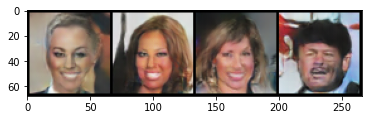

In [ ]:
noise = get_noise(4,z_dim,device='cpu')
imgs = gen_test(noise)
show_tensor_images(imgs,num_images=4)